In [1]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d5642e77-1895-467a-a4df-249cb7c9f988;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 177ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------

23/03/18 16:10:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/18 16:10:27 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/03/18 16:10:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
from graphframes import GraphFrame

ModuleNotFoundError: No module named 'graphframes'

In [75]:
# df = readCheckpoint(size='medium').cache()

In [76]:
# df.printSchema()

In [77]:
#filter to 3 malicious hosts

In [78]:
# df_first_events = get_firsts(df).cache()

In [79]:
# df_first_events.count()

In [80]:
# x is the number of hours
# y is the maximum number of events for any hour in a graph
# x_axis = 2*(x-1)+2
# y_axis = 2*(y-1)+2

In [81]:
# df_first_events.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet(f"{s3_url_trusted}/prod/graph/first_events")

In [82]:
df = spark.read.parquet(f"{s3_url_trusted}/prod/graph/first_events")\
            .withColumn("image_path", getFileUDF(col("image_path"))) \
            .withColumn("parent_image_path", getFileUDF(col("parent_image_path"))) \
            .withColumn("new_path", getFileUDF(col("new_path"))) \
            .withColumn("file_path", getFileUDF(col("file_path"))) \
            .cache()

In [83]:
df.limit(5).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,user_name,privileges,image_path,...,file_path,direction,logon_id,requesting_domain,requesting_user,event_minute,event_day,event_hour,malicious,relationship
0,c585477d-31ad-4408-bd25-6d7523adc016,2019-09-23 18:52:15.745,2d80a65e-5dae-4804-a636-7b4bb712fa04,0000fff8-2a47-4d1f-88e5-bdb1b5359ef0,FILE,READ,SysClient0718.systemia.com,None,None,geckodriver.exe,...,dbghelp.dll,None,None,None,None,52,23,18,0,0000fff8-2a47-4d1f-88e5-bdb1b5359ef0->2d80a65e...
1,9ae6334d-c87f-4bac-a851-62caada72ce9,2019-09-23 16:33:04.913,b399b339-76d4-4a34-acc3-1d9ae251559c,0001f527-a08c-4127-ba85-8c5a58171a6f,PROCESS,OPEN,SysClient0921.systemia.com,None,None,OneDriveSetup.exe,...,None,None,None,None,None,33,23,16,0,0001f527-a08c-4127-ba85-8c5a58171a6f->b399b339...
2,1d12de1f-d723-464f-b03d-0716d38e178c,2019-09-23 19:33:52.905,3871db48-f88e-4d49-a16d-02499ba99db0,00039093-cdf9-417c-86ba-aa25c5ed6949,FILE,READ,SysClient0863.systemia.com,None,None,svchost.exe,...,Microsoft-Windows-Storage-ClassPnP%4Operationa...,None,None,None,None,33,23,19,0,00039093-cdf9-417c-86ba-aa25c5ed6949->3871db48...
3,df83d5fd-a2e7-4f6a-954e-caeec17377b6,2019-09-23 16:44:44.871,967c95f1-5fbe-4de5-b8d3-5153607de22d,00039093-cdf9-417c-86ba-aa25c5ed6949,FILE,READ,SysClient0863.systemia.com,None,None,svchost.exe,...,Microsoft-Windows-AppXDeploymentServer%4Operat...,None,None,None,None,44,23,16,0,00039093-cdf9-417c-86ba-aa25c5ed6949->967c95f1...
4,d734fa9c-3880-421f-9d98-6a322d3ac34e,2019-09-23 16:32:05.121,004d8f8e-f6e3-4603-949a-8d2b21861691,0004f25c-e1f0-443f-a28f-be85dedb47ae,FILE,READ,SysClient0116.systemia.com,None,None,python.exe,...,packages,None,None,None,None,32,23,16,0,0004f25c-e1f0-443f-a28f-be85dedb47ae->004d8f8e...


In [84]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- objectID: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- object: string (nullable = true)
 |-- action: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- privileges: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- parent_image_path: string (nullable = true)
 |-- new_path: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- logon_id: string (nullable = true)
 |-- requesting_domain: string (nullable = true)
 |-- requesting_user: string (nullable = true)
 |-- event_minute: integer (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- event_hour: integer (nullable = true)
 |-- malicious: integer (nullable = true)
 |-- relationship: string (nullable = true)



In [85]:
#how big is this dataset with just first events? And how does the relationship work? 
df.count()

31170587

In [86]:
#What days are represented? 
df.select('event_day').distinct().show()

+---------+
|event_day|
+---------+
|       23|
+---------+



In [87]:
#how many hours? 
df.select('event_hour').distinct().show()
#I see all hours which means we likely filtered on 23 before we enmbarked on this journey. I think this might mean
#we have all the events. Exciting. 

+----------+
|event_hour|
+----------+
|        12|
|        22|
|        13|
|        16|
|         6|
|         3|
|        20|
|         5|
|        19|
|        15|
|        17|
|         9|
|         4|
|         8|
|        23|
|         7|
|        10|
|        21|
|        11|
|        14|
+----------+
only showing top 20 rows



In [88]:
df_benign = df.where(col('malicious') == 0)
df_benign.count()


31166945

In [89]:
df_benign_lim = df_benign.limit(500000)

In [90]:
df_mal = df.where(col('malicious') == 1)
df_mal.count()
#I'm not thrilled that the malicious count isn't even close to what was shown in the paper

3642

In [91]:
print("image path: "+str(df.select("image_path").distinct().count()))
print("image path: "+str(df.select("parent_image_path").distinct().count()))

image path: 153
image path: 151


In [92]:
df = df.limit(1000).cache()

In [93]:
df.count()

1000

In [94]:
# Create distinct vertices with source as actorid, destination as objectid
src_vertices = df_benign_lim.selectExpr('actorID as id').distinct()
dst_vertices = df_benign_lim.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_benign_lim.selectExpr('actorID as src', 'objectID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
g = GraphFrame(vertices, edges)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [95]:
# Create distinct vertices with source as actorid, destination as objectid for malicious
src_vertices = df_mal.selectExpr('actorID as id').distinct()
dst_vertices = df_mal.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_mal.selectExpr('actorID as src', 'objectID as dst', 'timestamp', 'object', 'action', 'hostname', 'user_name', 'privileges', 'image_path',
                      'parent_image_path', 'new_path', 'file_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user', 'malicious')

# Create GraphFrame
g = GraphFrame(vertices, edges)

In [96]:
# display the vertices
print("Vertices:")
g.vertices.show()

Vertices:
+--------------------+
|                  id|
+--------------------+
|d5846376-9596-428...|
|4a3392b6-acc8-4c2...|
|1006f812-b221-46f...|
|64c0966e-66f8-452...|
|bff0865c-96aa-4fb...|
|96913629-c1c9-450...|
|473d7954-6271-43b...|
|2d02ab42-4400-404...|
|70ba4f9c-e27b-4a3...|
|8c371c26-73a6-420...|
|e490633e-4e82-4bb...|
|a9fda05d-c2e2-466...|
|ee99fcf7-84fa-49f...|
|e68ba31f-8c2d-471...|
|1415fe71-91a1-423...|
|53efe8c9-3c95-4df...|
|4b7c800a-1689-494...|
|83279f19-6af6-453...|
|c239b575-3fc2-481...|
|97cfe185-0a9c-48d...|
+--------------------+
only showing top 20 rows



In [97]:
# display the edges
print("Edges:")
g.edges.show(5)

Edges:
+--------------------+--------------------+--------------------+-------+------+--------------------+---------+----------+--------------+-----------------+--------+--------------------+---------+--------+-----------------+---------------+---------+
|                 src|                 dst|           timestamp| object|action|            hostname|user_name|privileges|    image_path|parent_image_path|new_path|           file_path|direction|logon_id|requesting_domain|requesting_user|malicious|
+--------------------+--------------------+--------------------+-------+------+--------------------+---------+----------+--------------+-----------------+--------+--------------------+---------+--------+-----------------+---------------+---------+
|3eea9071-9ceb-468...|64baa9d3-17e2-4f9...|2019-09-23 17:55:...|   FILE|  READ|SysClient0660.sys...|     null|      null|powershell.exe|             null|    null|MSFT_WsdPrinterPo...|     null|    null|             null|           null|        1|
|

In [98]:
g.inDegrees.show(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|bd92be9f-1823-465...|       1|
|3ddb5f5d-9a09-415...|       1|
|ff43a0aa-4930-468...|       1|
|db532b31-916a-428...|       1|
|bb90307d-0998-403...|       1|
+--------------------+--------+
only showing top 5 rows



In [99]:
# find all paths of length 6 in the graph
# Handling null values in shorter length 
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
#motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f); (f)-[e6]->(g)")


In [100]:
# filter paths to only those where all edges are connected
connected_paths_2 = motifs2.filter("e1.dst = e2.src")# and e2.dst = e3.src and e3.dst = e4.src and e4.dst = e5.src and e5.dst = e6.src")

connected_paths_2.count()

7250

In [101]:
# filter paths to only those where all edges are connected
connected_paths = motifs6.filter("e1.dst = e2.src and e2.dst = e3.src and e3.dst = e4.src and e4.dst = e5.src and e5.dst = e6.src")
connected_paths.count()
#interesting that motif of 6 returns so many more
#for everyone's awareness, this took a long long time with 500000 benign events, so long that I had to shut it down


21135

In [ ]:
# get the 6 edges in each path and convert to a pandas dataframe
connected_paths.select("e1").limit(1).collect()

In [ ]:
type(connected_paths)

## DO NOT OVERWRITE /TEST_BIG. Please change the file path before saving again. 

In [ ]:
connected_paths.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet(f"{s3_url_trusted}/prod/graph/test_big")

In [35]:
connected_paths = spark.read.parquet(f"{s3_url_trusted}/prod/graph/test").cache()

In [36]:
connected_paths.limit(5).toPandas()

,a,e1,b,e2,c,e3,d,e4,e,e5,f,e6,g
0,"(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, c3d7e86...","(c3d7e86e-fd61-4980-a2a4-8ddb7d5ce080,)"
1,"(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 8ae4dd9...","(8ae4dd98-1e4c-4269-bba8-2823e84b439b,)"
2,"(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 7a2784d...","(7a2784d1-606e-48a8-908f-91489f95b79e,)"
3,"(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 479146b...","(479146bd-1a30-41d2-85c1-e3ba161295c9,)"
4,"(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, b8d04c1...","(b8d04c1a-ccdc-4e45-aa77-1c88f6dfab18,)"


In [37]:
#transpose values first by creating a trace column
# Add a new column "new_col" with ascending values starting at 1 before all other columns
df_transp = connected_paths.withColumn("Trace", (monotonically_increasing_id() + 1))
df_transp = df_transp.select("Trace", 
                             *[col for col in df_transp.columns if col != "Trace"])


In [38]:
df_transp.limit(1).toPandas()

,Trace,a,e1,b,e2,c,e3,d,e4,e,e5,f,e6,g
0,1,"(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4...","(2d02ab42-4400-4049-baad-6dfae19c3c4c,)","(2d02ab42-4400-4049-baad-6dfae19c3c4c, c3d7e86...","(c3d7e86e-fd61-4980-a2a4-8ddb7d5ce080,)"


In [39]:
#drop all vertices
df_transp = df_transp.drop('a','b','c','d','e','f','g')

In [40]:
df_transp.printSchema()

root
 |-- Trace: long (nullable = false)
 |-- e1: struct (nullable = true)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- timestamp: timestamp (nullable = true)
 |    |-- object: string (nullable = true)
 |    |-- action: string (nullable = true)
 |    |-- hostname: string (nullable = true)
 |    |-- user_name: string (nullable = true)
 |    |-- privileges: string (nullable = true)
 |    |-- image_path: string (nullable = true)
 |    |-- parent_image_path: string (nullable = true)
 |    |-- new_path: string (nullable = true)
 |    |-- file_path: string (nullable = true)
 |    |-- direction: string (nullable = true)
 |    |-- logon_id: string (nullable = true)
 |    |-- requesting_domain: string (nullable = true)
 |    |-- requesting_user: string (nullable = true)
 |    |-- malicious: integer (nullable = true)
 |-- e2: struct (nullable = true)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- timestamp: t

In [41]:
#transpose rows 
stacked_df = df_transp.selectExpr(
    "Trace", 
    "posexplode(array(e1, e2, e3, e4, e5, e6)) as (pos, col)"
).select(
    "Trace", 
    expr('''CASE pos 
    WHEN 0 THEN 'e1' 
    WHEN 1 THEN 'e2'
    WHEN 2 THEN 'e3'
    WHEN 3 THEN 'e4'
    WHEN 4 THEN 'e5'
    ELSE 'e6' END''').alias("event"),
    "col"
).orderBy("Trace","event")

stacked_df.limit(7).toPandas()

,Trace,event,col
0,1,e1,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4..."
1,1,e2,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4..."
2,1,e3,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4..."
3,1,e4,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4..."
4,1,e5,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4..."
5,1,e6,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, c3d7e86..."
6,2,e1,"(2d02ab42-4400-4049-baad-6dfae19c3c4c, 2d02ab4..."


In [42]:
#explode columns
stacked_df.printSchema()

root
 |-- Trace: long (nullable = false)
 |-- event: string (nullable = false)
 |-- col: struct (nullable = true)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- timestamp: timestamp (nullable = true)
 |    |-- object: string (nullable = true)
 |    |-- action: string (nullable = true)
 |    |-- hostname: string (nullable = true)
 |    |-- user_name: string (nullable = true)
 |    |-- privileges: string (nullable = true)
 |    |-- image_path: string (nullable = true)
 |    |-- parent_image_path: string (nullable = true)
 |    |-- new_path: string (nullable = true)
 |    |-- file_path: string (nullable = true)
 |    |-- direction: string (nullable = true)
 |    |-- logon_id: string (nullable = true)
 |    |-- requesting_domain: string (nullable = true)
 |    |-- requesting_user: string (nullable = true)
 |    |-- malicious: integer (nullable = true)



In [43]:
#explode columns
stacked_df = stacked_df.select(*stacked_df.columns, "col.*").drop('col')

In [44]:
stacked_df.printSchema()

root
 |-- Trace: long (nullable = false)
 |-- event: string (nullable = false)
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- object: string (nullable = true)
 |-- action: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- privileges: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- parent_image_path: string (nullable = true)
 |-- new_path: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- logon_id: string (nullable = true)
 |-- requesting_domain: string (nullable = true)
 |-- requesting_user: string (nullable = true)
 |-- malicious: integer (nullable = true)



In [45]:
stacked_df.limit(10).toPandas()
#TODO: we have a problem with graphframes, need to remove all traces that loop to themselves. 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious
0,1,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
1,1,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
2,1,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
3,1,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
4,1,e5,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
5,1,e6,2d02ab42-4400-4049-baad-6dfae19c3c4c,c3d7e86e-fd61-4980-a2a4-8ddb7d5ce080,2019-09-23 18:45:07.119,FILE,READ,SysClient0609.systemia.com,None,None,powershell.exe,None,None,Microsoft.PowerShell.Commands.Management.ni.dll,None,None,None,None,1
6,2,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
7,2,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
8,2,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
9,2,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1


In [71]:
#lets do some onehot encoding. let's start with object. 

#create sparse vecotrs for child objects
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
#turn into numeric index before encoding
indexer = StringIndexer(inputCol='new_path', outputCol='np_numeric')
indexer_fitted = indexer.fit(stacked_df)
df_indexed = indexer_fitted.transform(stacked_df)

if len(indexer_fitted.labels) > 0:

    encoder = OneHotEncoder(inputCols=['np_numeric'], outputCols=['np_sparse'],dropLast=False)
    df_onehot_np = encoder.fit(df_indexed).transform(df_indexed)
    df_onehot_np = df_onehot_np.drop('np_numeric')
    print(indexer_fitted.labels)
    df_onehot_np.limit(1).show()
else:
    print('only none')



only none


In [78]:
def oneHotCol(df, colm, dict_mapping):
    
    #now action
    #turn into numeric index before encoding
    
    num = colm+'_numeric'
    sparse = colm+'_sparse'
    indexer = StringIndexer(inputCol=colm, outputCol=num, handleInvalid="keep")
    indexer_fitted = indexer.fit(df)
    df_indexed = indexer_fitted.transform(df)

    encoder = OneHotEncoder(inputCols=[num], outputCols=[sparse],dropLast=False)
    df_onehot = encoder.fit(df_indexed).transform(df_indexed)
    df_onehot = df_onehot.drop(colm, num)

    #set dict to mapping
    dict_mapping[colm] = indexer_fitted.labels
        
    return df_onehot, dict_mapping
    

In [61]:
#use function to create object ohe
dict_mapping = {}
df_onehot, dict_mapping = oneHotCol(stacked_df,'object', dict_mapping)
print(dict_mapping['object'])
df_onehot.limit(1).toPandas()

['PROCESS', 'FILE', 'SHELL']


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious,object_sparse
0,1,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,"(1.0, 0.0, 0.0)"


In [80]:
#now do it for all other columns
list_cols = ['object','action','user_name', 'privileges',
             'image_path','parent_image_path','new_path',
             'direction','logon_id','requesting_domain',
             'requesting_user','file_path']
df_onehot = stacked_df
for colm in list_cols:
    df_onehot, dict_mapping = oneHotCol(df_onehot,colm, dict_mapping)
    #print(dict_mapping[colm])
    print(colm)

print(dict_mapping.keys())
df_onehot.limit(1).toPandas()
    

object
action
user_name
privileges
image_path
parent_image_path
new_path


direction
logon_id
requesting_domain
requesting_user
file_path
dict_keys(['object', 'action', 'image_path', 'parent_image_path', 'new_path', 'user_name', 'file_path'])


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,hostname,malicious,object_sparse,action_sparse,image_path_sparse,parent_image_path_sparse,file_path_sparse
0,1,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,SysClient0609.systemia.com,1,"(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [82]:
dict_mapping['file_path']

['ModuleAnalysisCache',
 'Microsoft.Management.Infrastructure.ni.dll.aux',
 'System.Data.ni.dll.aux',
 'System.DirectoryServices.ni.dll.aux',
 'System.Transactions.ni.dll.aux',
 'System.Numerics.ni.dll.aux',
 'System.Xml.ni.dll.aux',
 'wbemprox.dll',
 'System.Management.ni.dll.aux',
 'pnrpnsp.dll',
 'Microsoft-OneCore-CoreSystem-onecore-Package~31bf3856ad364e35~amd64~~10.0.15063.0.cat',
 'Microsoft.CSharp.ni.dll.aux',
 'System.Management.Automation.ni.dll.aux',
 'wbemcomn.dll',
 'System.Configuration.ni.dll.aux',
 'Package_2715_for_KB4493474~31bf3856ad364e35~amd64~~10.0.1.5.cat',
 'IPHLPAPI.DLL',
 'Microsoft.PowerShell.Commands.Management.ni.dll.aux',
 'Microsoft.PowerShell.Commands.Utility.ni.dll.aux',
 'Microsoft.PowerShell.Management.psd1',
 'Microsoft.PowerShell.Utility.psd1',
 'Microsoft.PowerShell.Utility.psm1',
 'System.Configuration.Install.ni.dll.aux',
 'Microsoft-Windows-Client-Features-Package-AutoMerged-ds~31bf3856ad364e35~amd64~~10.0.15063.0.cat',
 'BitLocker.psd1',
 'Micr

In [84]:
#use new function to transpose and explode trace and then one hot all the columns you want. Return encoded df 
#and dropped columns. 
%run trace_encode.ipynb

In [86]:
list_cols = ['object','action','user_name', 'privileges',
             'image_path','parent_image_path','new_path',
             'direction','logon_id','requesting_domain',
             'requesting_user']
df_test, dict_test = trace_encode(connected_paths,list_cols)

In [88]:
print(dict_test.keys())
df_test.limit(1).toPandas()

dict_keys(['object', 'action', 'user_name', 'privileges', 'image_path', 'parent_image_path', 'new_path', 'direction', 'logon_id', 'requesting_domain', 'requesting_user'])


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,hostname,file_path,malicious,object_sparse,action_sparse,user_name_sparse,privileges_sparse,image_path_sparse,parent_image_path_sparse,new_path_sparse,direction_sparse,logon_id_sparse,requesting_domain_sparse,requesting_user_sparse
0,1,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,SysClient0609.systemia.com,None,1,"(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",(1.0),(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)",(1.0),(1.0),(1.0),(1.0),(1.0)


In [89]:
dict_test['image_path']

['powershell.exe',
 'PING.EXE',
 'conhost.exe',
 'csc.exe',
 'more.com',
 'net.exe',
 'whoami.exe',
 'schtasks.exe',
 'taskkill.exe']

In [ ]:
#so this is pretty fast for malicious connected, what about benign


In [18]:
# using split and applying in ml with pypark
train, test, val = connected_paths.randomSplit([0.80, 0.15, 0.05], seed=12345)

In [22]:
val.count()

9

In [46]:
# create new dataframe to union and create duplicate rows
df_dup = df.withColumn('id', lit(None).cast(StringType()))

In [47]:
df_dup.limit(5).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,user_name,privileges,image_path,...,file_path,direction,logon_id,requesting_domain,requesting_user,event_minute,event_day,event_hour,malicious,relationship
0,None,2019-09-23 18:52:15.745,2d80a65e-5dae-4804-a636-7b4bb712fa04,0000fff8-2a47-4d1f-88e5-bdb1b5359ef0,FILE,READ,SysClient0718.systemia.com,None,None,geckodriver.exe,...,dbghelp.dll,None,None,None,None,52,23,18,0,0000fff8-2a47-4d1f-88e5-bdb1b5359ef0->2d80a65e...
1,None,2019-09-23 16:33:04.913,b399b339-76d4-4a34-acc3-1d9ae251559c,0001f527-a08c-4127-ba85-8c5a58171a6f,PROCESS,OPEN,SysClient0921.systemia.com,None,None,OneDriveSetup.exe,...,None,None,None,None,None,33,23,16,0,0001f527-a08c-4127-ba85-8c5a58171a6f->b399b339...
2,None,2019-09-23 19:33:52.905,3871db48-f88e-4d49-a16d-02499ba99db0,00039093-cdf9-417c-86ba-aa25c5ed6949,FILE,READ,SysClient0863.systemia.com,None,None,svchost.exe,...,Microsoft-Windows-Storage-ClassPnP%4Operationa...,None,None,None,None,33,23,19,0,00039093-cdf9-417c-86ba-aa25c5ed6949->3871db48...
3,None,2019-09-23 16:44:44.871,967c95f1-5fbe-4de5-b8d3-5153607de22d,00039093-cdf9-417c-86ba-aa25c5ed6949,FILE,READ,SysClient0863.systemia.com,None,None,svchost.exe,...,Microsoft-Windows-AppXDeploymentServer%4Operat...,None,None,None,None,44,23,16,0,00039093-cdf9-417c-86ba-aa25c5ed6949->967c95f1...
4,None,2019-09-23 16:32:05.121,004d8f8e-f6e3-4603-949a-8d2b21861691,0004f25c-e1f0-443f-a28f-be85dedb47ae,FILE,READ,SysClient0116.systemia.com,None,None,python.exe,...,packages,None,None,None,None,32,23,16,0,0004f25c-e1f0-443f-a28f-be85dedb47ae->004d8f8e...


In [48]:
df_new = df.union(df_dup).sort("timestamp").cache()
df.unpersist()

DataFrame[id: string, timestamp: timestamp, objectID: string, actorID: string, object: string, action: string, hostname: string, user_name: string, privileges: string, image_path: string, parent_image_path: string, new_path: string, file_path: string, direction: string, logon_id: string, requesting_domain: string, requesting_user: string, event_minute: int, event_day: int, event_hour: int, malicious: int, relationship: string]

In [49]:
df_new.limit(5).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,user_name,privileges,image_path,...,file_path,direction,logon_id,requesting_domain,requesting_user,event_minute,event_day,event_hour,malicious,relationship
0,7065c8c5-8755-4063-8c3e-3857c1686715,2019-09-23 07:02:59.986,0054f4d1-1bfd-4898-9f42-20df1512fd4c,0054f4d1-1bfd-4898-9f42-20df1512fd4c,PROCESS,OPEN,SysClient0222.systemia.com,None,None,conhost.exe,...,None,None,None,None,None,2,23,7,0,0054f4d1-1bfd-4898-9f42-20df1512fd4c->0054f4d1...
1,None,2019-09-23 07:02:59.986,0054f4d1-1bfd-4898-9f42-20df1512fd4c,0054f4d1-1bfd-4898-9f42-20df1512fd4c,PROCESS,OPEN,SysClient0222.systemia.com,None,None,conhost.exe,...,None,None,None,None,None,2,23,7,0,0054f4d1-1bfd-4898-9f42-20df1512fd4c->0054f4d1...
2,8e939d91-0d83-424f-9780-eaf48510a8b7,2019-09-23 10:05:59.830,209804ab-d6b1-4146-b70d-b64d782a9e14,0093ae7a-a3c2-4fb2-a929-d8fb2a8cd0df,PROCESS,OPEN,SysClient0222.systemia.com,None,None,SearchFilterHost.exe,...,None,None,None,None,None,5,23,10,0,0093ae7a-a3c2-4fb2-a929-d8fb2a8cd0df->209804ab...
3,None,2019-09-23 10:05:59.830,209804ab-d6b1-4146-b70d-b64d782a9e14,0093ae7a-a3c2-4fb2-a929-d8fb2a8cd0df,PROCESS,OPEN,SysClient0222.systemia.com,None,None,SearchFilterHost.exe,...,None,None,None,None,None,5,23,10,0,0093ae7a-a3c2-4fb2-a929-d8fb2a8cd0df->209804ab...
4,90cf6487-badf-4ec6-a292-826806bb2f22,2019-09-23 13:06:55.086,ca2e020c-3407-4349-9328-d45dfc962fb9,0095d569-f12a-4bd8-9912-061948830795,FILE,READ,SysClient0875.systemia.com,None,None,taskhostw.exe,...,propsys.dll,None,None,None,None,6,23,13,0,0095d569-f12a-4bd8-9912-061948830795->ca2e020c...


In [ ]:
# len(df_new.select('relationship').distinct().collect())

In [ ]:
tot = df_new.count()

In [ ]:
df_ratios = df_new.groupBy("object") \
              .count() \
              .withColumnRenamed('count', 'cnt_per_group') \
              .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
              .cache()

In [ ]:
df_ratios.limit(5).toPandas()

In [ ]:
df_new.limit(5).toPandas()

In [ ]:
connected_paths.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet(f"{s3_url_trusted}/prod/graph/test")

In [50]:
stacked_df.limit(10).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious
0,1,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
1,1,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
2,1,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
3,1,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
4,1,e5,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
5,1,e6,2d02ab42-4400-4049-baad-6dfae19c3c4c,c3d7e86e-fd61-4980-a2a4-8ddb7d5ce080,2019-09-23 18:45:07.119,FILE,READ,SysClient0609.systemia.com,None,None,powershell.exe,None,None,Microsoft.PowerShell.Commands.Management.ni.dll,None,None,None,None,1
6,2,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
7,2,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
8,2,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1
9,2,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1


In [51]:
# Reference: https://stackoverflow.com/questions/36725353/applying-a-window-function-to-calculate-differences-in-pyspark

from pyspark.sql import Window
from pyspark.sql.functions import lag, col, coalesce, lit

# Define the window specification
window_spec = Window.partitionBy("Trace").orderBy("timestamp")

# Calculate the timestamp difference between the current event and the preceding event
stacked_df = stacked_df.withColumn(
    "timestamp_difference",
    coalesce(
        (col("timestamp").cast("long") - lag(col("timestamp").cast("long")).over(window_spec)) * 1000
        + (col("timestamp").cast("double") % 1 - lag(col("timestamp").cast("double")).over(window_spec) % 1) * 1000,
        lit(None).cast("double")
    )
)

stacked_df.limit(10).toPandas()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious,timestamp_difference
0,6,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,NaN
1,6,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
2,6,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
3,6,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
4,6,e5,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
5,6,e6,2d02ab42-4400-4049-baad-6dfae19c3c4c,b8d04c1a-ccdc-4e45-aa77-1c88f6dfab18,2019-09-23 18:44:59.344,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,3.000021
6,7,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,NaN
7,7,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
8,7,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
9,7,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000


In [52]:
# filter rows where 'Trace' equals 642 to test code
filtered_df = stacked_df.filter(stacked_df.Trace == 642)
filtered_df.toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious,timestamp_difference
0,642,e4,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:17.240,PROCESS,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,wmiprvse.exe,None,None,None,None,None,None,1,NaN
1,642,e1,3eea9071-9ceb-468a-ad89-9e3890833e52,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:17.347,PROCESS,OPEN,SysClient0660.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,106.999874
2,642,e2,3eea9071-9ceb-468a-ad89-9e3890833e52,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:17.347,PROCESS,OPEN,SysClient0660.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
3,642,e5,3eea9071-9ceb-468a-ad89-9e3890833e52,3eea9071-9ceb-468a-ad89-9e3890833e52,2019-09-23 17:34:17.347,PROCESS,OPEN,SysClient0660.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
4,642,e6,3eea9071-9ceb-468a-ad89-9e3890833e52,b3736e65-b300-4f92-9d15-2b0b59cb5d9d,2019-09-23 17:34:20.279,FILE,CREATE,SysClient0660.systemia.com,None,None,powershell.exe,None,None,__PSScriptPolicyTest_eipbzfxu.3b4.psm1,None,None,None,None,1,2932.000160
5,642,e3,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,2019-09-23 17:43:13.564,PROCESS,OPEN,SysClient0660.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,533284.999847


In [55]:
# Check above code

from datetime import datetime

timestamp1 = "2019-09-23 17:34:20.279"
timestamp2 = "2019-09-23 17:43:13.564"

# Convert the string timestamps to datetime objects
dt1 = datetime.strptime(timestamp1, "%Y-%m-%d %H:%M:%S.%f")
dt2 = datetime.strptime(timestamp2, "%Y-%m-%d %H:%M:%S.%f")

# Calculate the time difference
time_difference = dt2 - dt1

# Convert the time difference to milliseconds
time_difference_ms = time_difference.total_seconds() * 1000

print("Time difference (in milliseconds):", time_difference_ms)

Time difference (in milliseconds): 533285.0


In [56]:
# Above code in function format

from pyspark.sql import Window
from pyspark.sql.functions import lag, col, coalesce, lit

def calculate_timestamp_difference(stacked_df):
    # Define the window specification
    window_spec = Window.partitionBy("Trace").orderBy("timestamp")

    # Calculate the timestamp difference between the current event and the preceding event
    result_df = stacked_df.withColumn(
        "timestamp_difference",
        coalesce(
            (col("timestamp").cast("long") - lag(col("timestamp").cast("long")).over(window_spec)) * 1000
            + (col("timestamp").cast("double") % 1 - lag(col("timestamp").cast("double")).over(window_spec) % 1) * 1000,
            lit(None).cast("double")
        )
    )

    return result_df

# Usage example
result_df = calculate_timestamp_difference(stacked_df)
result_df.limit(10).toPandas()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,image_path,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious,timestamp_difference
0,6,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,NaN
1,6,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
2,6,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
3,6,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
4,6,e5,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
5,6,e6,2d02ab42-4400-4049-baad-6dfae19c3c4c,b8d04c1a-ccdc-4e45-aa77-1c88f6dfab18,2019-09-23 18:44:59.344,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,3.000021
6,7,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,NaN
7,7,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
8,7,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000
9,7,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,powershell.exe,powershell.exe,None,None,None,None,None,None,1,0.000000


In [67]:
# Reference for Bucketizer: https://stackoverflow.com/questions/46225587/how-to-bin-in-pyspark
# Leveraged ChatGPT 4 to create bin edges to feed into Bucketizer

from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F

# if timestamp_bins exists then drop the column
stacked_df = stacked_df.drop("timestamp_bins")

# calculate the min and max values of the timestamp_difference column
min_max = stacked_df.agg(F.min("timestamp_difference").alias("min"), F.max("timestamp_difference").alias("max")).collect()
min_val = min_max[0]["min"]
max_val = min_max[0]["max"]

# calculate the bin width
bin_width = (max_val - min_val) / 10

# create the bin edges by starting from negative infinity to capture
# the smallest values. Subsequently, add that to the minimum value to
# create a list of the ending points for each group. It starts from the 
# minimum value (min_val) and adds the size of each group (bin_width) 
# multiplied by a number i from 1 to 10.
bins = [float('-inf')] + [min_val + i * bin_width for i in range(1, 11)]

# print the bins
bin_ranges = [f"{lower:.2f} - {upper:.2f}" for lower, upper in zip(bins[:-1], bins[1:])]
print("Bins:", bin_ranges)

# create a Bucketizer instance
bucketizer = Bucketizer(splits=bins, inputCol="timestamp_difference", outputCol="timestamp_bins")

# transform the DataFrame
stacked_df = bucketizer.transform(stacked_df)

# increment the bin index by 1 to start from bin 1 instead of 0,
# code was initially putting timestamp differences of 0 in bin 0,
# thus code is needed to correctly bin these items to bin 1
stacked_df = stacked_df.withColumn("timestamp_bins", F.col("timestamp_bins") + 1)


stacked_df.limit(10).toPandas()

Bins: ['-inf - 705599.20', '705599.20 - 1411198.40', '1411198.40 - 2116797.60', '2116797.60 - 2822396.80', '2822396.80 - 3527996.00', '3527996.00 - 4233595.20', '4233595.20 - 4939194.40', '4939194.40 - 5644793.60', '5644793.60 - 6350392.80', '6350392.80 - 7055992.00']


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,...,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious,timestamp_difference,timestamp_bins
0,6,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
1,6,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
2,6,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
3,6,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
4,6,e5,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
5,6,e6,2d02ab42-4400-4049-baad-6dfae19c3c4c,b8d04c1a-ccdc-4e45-aa77-1c88f6dfab18,2019-09-23 18:44:59.344,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,3.000021,1.0
6,7,e1,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
7,7,e2,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
8,7,e3,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0
9,7,e4,2d02ab42-4400-4049-baad-6dfae19c3c4c,2d02ab42-4400-4049-baad-6dfae19c3c4c,2019-09-23 18:44:59.341,PROCESS,OPEN,SysClient0609.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,0.000000,1.0


In [68]:
# show records in bin 9 for testing

bin_9_records = stacked_df.filter(stacked_df.timestamp_bins == 9)

# Show the result
bin_9_records.limit(10).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Trace,event,src,dst,timestamp,object,action,hostname,user_name,privileges,...,parent_image_path,new_path,file_path,direction,logon_id,requesting_domain,requesting_user,malicious,timestamp_difference,timestamp_bins
0,6519,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,9985801a-6c2f-4432-90c9-66b815bc097c,2019-09-23 17:21:38.834,FILE,READ,SysClient0201.systemia.com,None,None,...,None,None,Package_2123_for_KB4493474~31bf3856ad364e35~am...,None,None,None,None,1,6.077430e+06,9.0
1,6526,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,3b03a9b8-13bb-4910-b094-7307975d3ed3,2019-09-23 17:15:12.441,PROCESS,CREATE,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.691037e+06,9.0
2,6535,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,62ce1c4f-13e0-4df1-8f9e-47796e2db2fa,2019-09-23 17:15:09.111,PROCESS,OPEN,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.687707e+06,9.0
3,6555,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,e9767c93-7c57-4882-bf03-b4b7cf2bdde8,2019-09-23 17:15:23.175,FILE,READ,SysClient0201.systemia.com,None,None,...,None,None,Functions,None,None,None,None,1,5.701771e+06,9.0
4,6563,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,4a7a2f95-cb39-4dc3-8b91-ea0ac4975672,2019-09-23 17:15:23.545,FILE,READ,SysClient0201.systemia.com,None,None,...,None,None,ScheduledTasks,None,None,None,None,1,5.702141e+06,9.0
5,6564,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,c1a230bf-e795-401f-a405-75ca28f26617,2019-09-23 17:15:01.528,PROCESS,CREATE,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.680124e+06,9.0
6,6566,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,45aa6548-7075-413d-8692-fc61652317e6,2019-09-23 17:15:11.130,PROCESS,CREATE,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.689726e+06,9.0
7,6578,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,01962cd7-0865-4877-a583-f7b1e200f54c,2019-09-23 17:15:17.125,PROCESS,OPEN,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.695721e+06,9.0
8,6580,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,e5904561-4497-4fb9-bdf3-53a2a24b1e6b,2019-09-23 17:15:04.516,PROCESS,CREATE,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.683112e+06,9.0
9,6587,e6,a52f6519-6265-4437-9f6c-3402fb245cc7,1752293c-f8f7-4f11-b19e-fda5308c570c,2019-09-23 17:15:06.710,PROCESS,CREATE,SysClient0201.systemia.com,None,None,...,powershell.exe,None,None,None,None,None,None,1,5.685306e+06,9.0


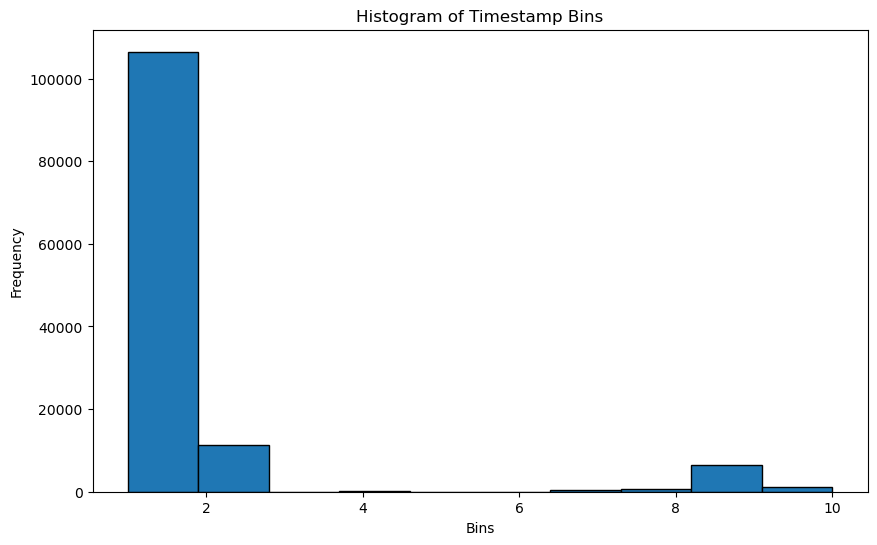

In [65]:
# histogram to show bin distribution

import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = stacked_df.select("timestamp_bins").toPandas()

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(pandas_df["timestamp_bins"], bins=10, edgecolor="black")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Histogram of Timestamp Bins")
plt.show()


## Code to test Motifs

In [70]:
from graphframes import GraphFrame

# Define the vertices (nodes)
vertices = spark.createDataFrame([
    ("A", "Node A"),
    ("B", "Node B"),
    ("C", "Node C"),
    ("D", "Node D"),
    ("E", "Node E"),
    ("F", "Node F")
], ["id", "name"])

# Define the edges (connections)
edges = spark.createDataFrame([
    ("A", "B"),
    ("B", "C"),
    ("C", "D"),
    ("D", "E"),
    ("E", "F")
], ["src", "dst"])

# Create a GraphFrame
g = GraphFrame(vertices, edges)

# Find all paths of length 6 in the graph
motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d); (d)-[e4]->(e); (e)-[e5]->(f)")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [72]:
# Print the results
motifs2.toPandas()


,a,e1,b,e2,c
0,"(A, Node A)","(A, B)","(B, Node B)","(B, C)","(C, Node C)"
1,"(B, Node B)","(B, C)","(C, Node C)","(C, D)","(D, Node D)"
2,"(C, Node C)","(C, D)","(D, Node D)","(D, E)","(E, Node E)"
3,"(D, Node D)","(D, E)","(E, Node E)","(E, F)","(F, Node F)"


In [73]:
motifs6.toPandas()

,a,e1,b,e2,c,e3,d,e4,e,e5,f
0,"(A, Node A)","(A, B)","(B, Node B)","(B, C)","(C, Node C)","(C, D)","(D, Node D)","(D, E)","(E, Node E)","(E, F)","(F, Node F)"


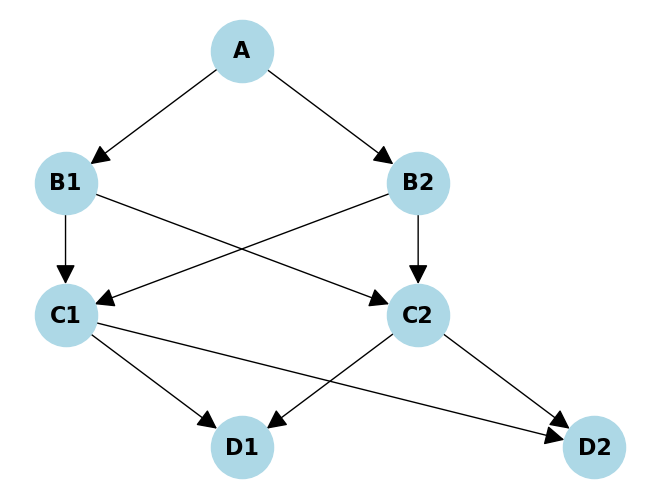

In [108]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['A', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2']
G.add_nodes_from(nodes)

# Add edges
edges = [
    ('A', 'B1'),
    ('A', 'B2'),
    ('B1', 'C1'),
    ('B1', 'C2'),
    ('B2', 'C1'),
    ('B2', 'C2'),
    ('C1', 'D1'),
    ('C1', 'D2'),
    ('C2', 'D1'),
    ('C2', 'D2'),
]
G.add_edges_from(edges)

# Define a hierarchical layout
pos = {
    'A': (0, 3),
    'B1': (-1, 2),
    'B2': (1, 2),
    'C1': (-1, 1),
    'C2': (1, 1),
    'D1': (0, 0),
    'D2': (2, 0),
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=16, font_weight='bold', arrowsize=30)
plt.show()




In [120]:
# Find all paths of length 6 in the graph

from graphframes import GraphFrame
from pyspark.sql.functions import col

# Create the vertices DataFrame
vertices = spark.createDataFrame([
    ('A',),
    ('B1',),
    ('B2',),
    ('C1',),
    ('C2',),
    ('D1',),
    ('D2',)
], ['id'])

# Create the edges DataFrame
edges = spark.createDataFrame([
    ('A', 'B1'),
    ('A', 'B2'),
    ('B1', 'C1'),
    ('B1', 'C2'),
    ('B2', 'C1'),
    ('B2', 'C2'),
    ('C1', 'D1'),
    ('C1', 'D2'),
    ('C2', 'D1'),
    ('C2', 'D2')
], ['src', 'dst'])

# Create the GraphFrame
g = GraphFrame(vertices, edges)

# Show the vertices and edges
print("Vertices:")
g.vertices.show()
print("Edges:")
g.edges.show()

# Find all the paths of length 3
paths = g.find("(a)-[]->(b); (b)-[]->(c)")
paths.show()

motifs2 = g.find("(a)-[e1]->(b); (b)-[e2]->(c)")
motifs6 = g.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(d)")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Vertices:
+---+
| id|
+---+
|  A|
| B1|
| B2|
| C1|
| C2|
| D1|
| D2|
+---+

Edges:
+---+---+
|src|dst|
+---+---+
|  A| B1|
|  A| B2|
| B1| C1|
| B1| C2|
| B2| C1|
| B2| C2|
| C1| D1|
| C1| D2|
| C2| D1|
| C2| D2|
+---+---+



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----+----+----+
|   a|   b|   c|
+----+----+----+
| {A}|{B1}|{C1}|
| {A}|{B2}|{C1}|
| {A}|{B1}|{C2}|
| {A}|{B2}|{C2}|
|{B2}|{C1}|{D1}|
|{B1}|{C1}|{D1}|
|{B2}|{C2}|{D1}|
|{B1}|{C2}|{D1}|
|{B2}|{C1}|{D2}|
|{B1}|{C1}|{D2}|
|{B2}|{C2}|{D2}|
|{B1}|{C2}|{D2}|
+----+----+----+



In [121]:
# Print the results
motifs2.toPandas()

,a,e1,b,e2,c
0,"(A,)","(A, B1)","(B1,)","(B1, C1)","(C1,)"
1,"(A,)","(A, B2)","(B2,)","(B2, C1)","(C1,)"
2,"(A,)","(A, B1)","(B1,)","(B1, C2)","(C2,)"
3,"(A,)","(A, B2)","(B2,)","(B2, C2)","(C2,)"
4,"(B2,)","(B2, C1)","(C1,)","(C1, D1)","(D1,)"
5,"(B1,)","(B1, C1)","(C1,)","(C1, D1)","(D1,)"
6,"(B2,)","(B2, C2)","(C2,)","(C2, D1)","(D1,)"
7,"(B1,)","(B1, C2)","(C2,)","(C2, D1)","(D1,)"
8,"(B2,)","(B2, C1)","(C1,)","(C1, D2)","(D2,)"
9,"(B1,)","(B1, C1)","(C1,)","(C1, D2)","(D2,)"


In [122]:
# Print the results
motifs6.toPandas()

,a,e1,b,e2,c,e3,d
0,"(A,)","(A, B2)","(B2,)","(B2, C1)","(C1,)","(C1, D1)","(D1,)"
1,"(A,)","(A, B1)","(B1,)","(B1, C1)","(C1,)","(C1, D1)","(D1,)"
2,"(A,)","(A, B2)","(B2,)","(B2, C2)","(C2,)","(C2, D1)","(D1,)"
3,"(A,)","(A, B1)","(B1,)","(B1, C2)","(C2,)","(C2, D1)","(D1,)"
4,"(A,)","(A, B2)","(B2,)","(B2, C1)","(C1,)","(C1, D2)","(D2,)"
5,"(A,)","(A, B1)","(B1,)","(B1, C1)","(C1,)","(C1, D2)","(D2,)"
6,"(A,)","(A, B2)","(B2,)","(B2, C2)","(C2,)","(C2, D2)","(D2,)"
7,"(A,)","(A, B1)","(B1,)","(B1, C2)","(C2,)","(C2, D2)","(D2,)"
